In [9]:
# import libraries
from pathlib import Path # handle files
from PIL import Image # check to see if images are readable
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import os

# EDA
# import cv2

In [10]:
# Since different operating systems use diferent path separations (windows: \, linux: /), path handles this automatically
raw_data = Path("../data/raw/chest_xray") # raw_data = os.path.join("data", "raw", "chest_xray")
train = raw_data / "train" # os.path.join(raw_data, "train")
test = raw_data / "test"
val = raw_data / "val"

In [11]:
# Data validation to check for unreadable files, and recording
# image label, size, and color mode
rows = []
bad_files = []

for class_dir in train.iterdir():
  if not class_dir.is_dir():
    continue
  
  label = class_dir.name # "NORMAL" and "PNEUMONIA" folder

  for img_path in class_dir.glob("*"): # iterate over all files
    try:
      with Image.open(img_path) as img:
        width, height = img.size
        mode = img.mode # pixel format and depth of image (e.g., "RGB", "L")

        # each row contains these columns
        rows.append({
          "path": str(img_path),
          "label": label,
          "width": width,
          "height": height,
          "mode": mode,
          "split": "train"
        })
    except Exception as e:
      bad_files.append({
        "path": str(img_path),
        "error": str(e)
      })

train_df = pd.DataFrame(rows)
bad_df = pd.DataFrame(bad_files)


In [12]:
print("Number of training images:", len(train_df))
print("\nClass distribution:")
print(train_df["label"].value_counts())

print("\nImage modes:")
print(train_df["mode"].value_counts())

print("\nImage size summary:")
train_df[["width", "height"]].describe()

Number of training images: 5216

Class distribution:
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

Image modes:
mode
L      4933
RGB     283
Name: count, dtype: int64

Image size summary:


,width,height
count,5216.000000,5216.000000
mean,1320.610813,968.074770
std,355.298743,378.855691
min,384.000000,127.000000
25%,1056.000000,688.000000
50%,1284.000000,888.000000
75%,1552.000000,1187.750000
max,2916.000000,2663.000000


In [13]:
# All images are readable
print(f"Number of unreadable training images: {len(bad_df)}")
bad_df.head()

Number of unreadable training images: 2


,path,error
0,..\data\raw\chest_xray\train\NORMAL\.DS_Store,cannot identify image file '..\\data\\raw\\che...
1,..\data\raw\chest_xray\train\PNEUMONIA\.DS_Store,cannot identify image file '..\\data\\raw\\che...


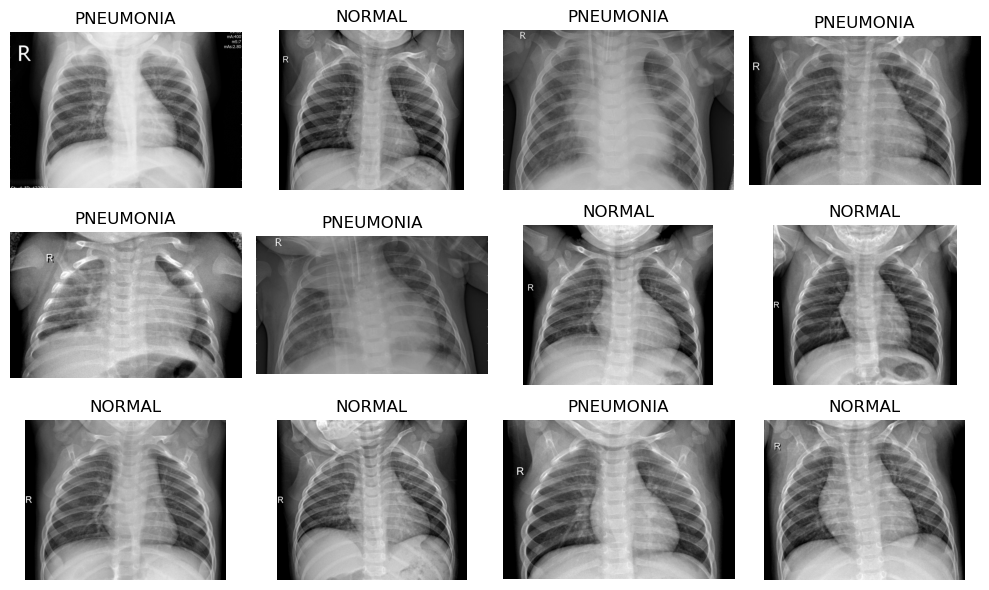

In [14]:
"""
Check to see if 12 random sample images from the training dataset looks correct
"""
sample = train_df.sample(12, random_state=42)

plt.figure(figsize=(10, 6))
for i, row in enumerate(sample.itertuples()): # Iterate over rows of the sample DataFrame
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1) # plot multiple plots using same axes
  plt.imshow(img, cmap="gray") # display data as an image in a plot
  plt.title(row.label) # each plot should display the image label as NORMAL or PNEUMONIA
  plt.axis("off")

plt.tight_layout()
plt.show()

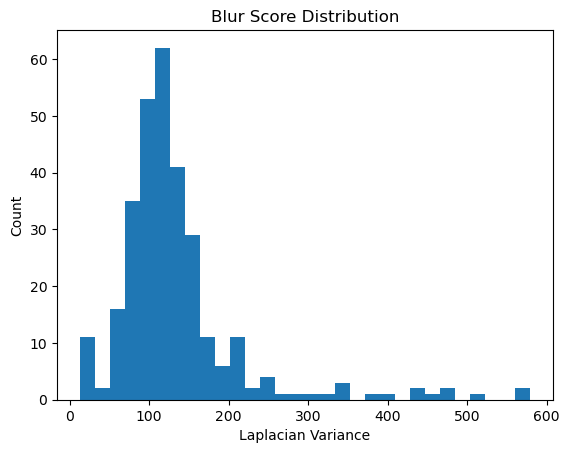

In [ ]:
"""
EDA for image quality
"""
import cv2

def blur_score(path):
  # load image from path and convert it to a numpy array in grayscale mode
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  # calculate variance of the laplacian of an immage to detect image blur
  # high variance -> wide spread of pixel values indicating many edges are present
  # low variance -> most pixel values are close to the mean indicating a blurry image
  return cv2.Laplacian(img, cv2.CV_64F).var()

sample_df = train_df.sample(300, random_state=0).copy()
sample_df["blur_score"] = sample_df["path"].apply(blur_score) # apply blur_score to each row in sample dataset
sample_df["blur_score"].describe()

plt.hist(sample_df["blur_score"], bins=30)
plt.title("Blur Score Distribution")
plt.xlabel("Laplacian Variance")
plt.ylabel("Count")
plt.show()

In [17]:
"""
Save metadata
"""
metadata_dir = Path("../data/metadata")
metadata_dir.mkdir(parents=True, exist_ok=True)

# Save training DataFrame to csv file, index=False prevents pandas
# from writing DataFrame index into CSV file in the first column
train_df.to_csv(metadata_dir / "raw_train_inventory.csv", index=False)
bad_df.to_csv(metadata_dir / "raw_corrupted_files.csv", index=False)

print("Saved metadata files to data/metadata/")

Saved metadata files to data/metadata/
